# Chapter 4. 
# Regression and Prediction

import required Python packages

In [37]:
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import OLSInfluence

from pygam import LinearGAM, s, l
from pygam.datasets import wage

import seaborn as sns
import matplotlib.pyplot as plt

from dmba import stepwise_selection
from dmba import AIC_score

no display found. Using non-interactive agg backend

In [2]:
%matplotlib inline

In [3]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [4]:
LUNG_CSV = DATA / 'LungDisease.csv'
HOUSE_CSV = DATA / 'house_sales.csv'

## Simple Linear Regression
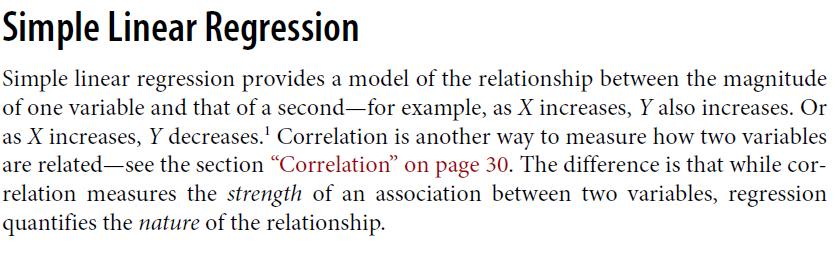

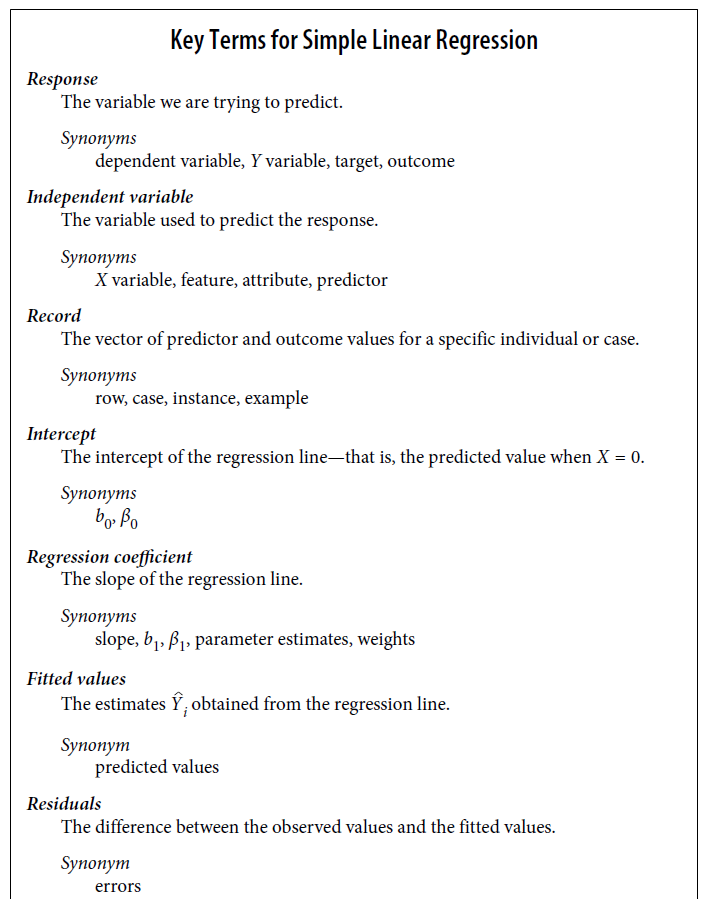
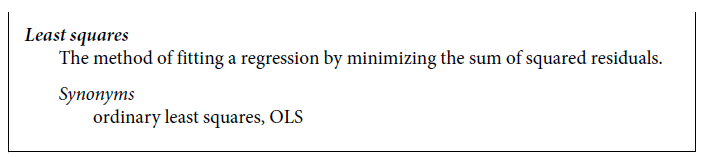
## The Regression Equation

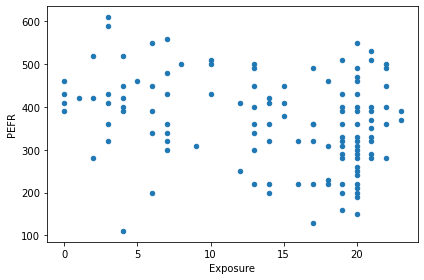

In [7]:
#F4-1 Cotton exposure versus lung capacity
lung = pd.read_csv(LUNG_CSV)
# lung.head(10)
lung.plot.scatter(x='Exposure', y='PEFR')

plt.tight_layout()
plt.show()

We can use the `LinearRegression` model from scikit-learn.

In [8]:
predictors =['Exposure']
outcome = "PEFR"

model = LinearRegression()
model.fit(lung[predictors], lung[outcome])

print(f'Intercept: {model.intercept_:3f}')
print(f"Coeficient Exposure: {model.coef_[0]:.3f}")



Intercept: 424.582807
Coeficient Exposure: -4.185


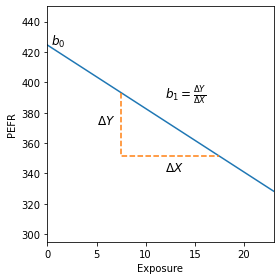

In [10]:
#F4-2 Slope and intercept for the regression fit to the lung data
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_xlim(0, 23)
ax.set_ylim(295, 450)
ax.set_xlabel("Exposure")
ax.set_ylabel("PEFR")
ax.plot((0, 23), model.predict([[0],[23]]))
ax.text(0.4, model.intercept_, r"$b_0$", size="larger")

x = [[7.5], [17.5]]
y = model.predict(x)
ax.plot((7.5, 7.5, 17.5), (y[0], y[1], y[1]), "--")
ax.text(5, np.mean(y), r"$\Delta Y$", size="larger")
ax.text(12, y[1] - 10, r"$\Delta X$", size="larger")
ax.text(12, 390, r"$b_1 = \frac{\Delta Y}{\Delta X}$", size="larger")

plt.tight_layout()
plt.show()

## Fitted Values and Residuals
The method `predict` of a fitted scikit-learn model can be used to predict new data points.

In [12]:
#Fig 4-3 ilustrates the residual from the regression line to fit to the lung data
fitted = model.predict(lung[predictors])
residuals = lung[outcome] - fitted

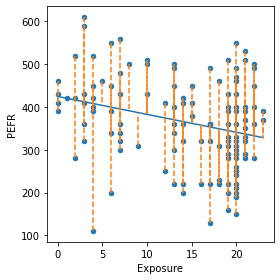

In [14]:
"""Fig 4-3 Residual from a regression line(to accommodate all the dat, 
the y-axis scale differs from Fig4-2, hence the apparently different slope)"""

ax = lung.plot.scatter(x="Exposure", y="PEFR", figsize=(4, 4))
ax.plot(lung.Exposure, fitted)
for x, yactual, yfitted in zip(lung.Exposure, lung.PEFR, fitted):
    ax.plot((x, x), (yactual, yfitted), "--", color="C1")
    
plt.tight_layout()
plt.show()

## Multiple Linear Regression

### Example: King Couty Housing Data

An example of using multiple linear regression is in estimating the value of houses.
County assessors must estimate the value of a house for the purposes of assessing
taxes. Real estate professionals and home buyers consult popular websites such as Zillow
to ascertain a fair price. Here are a few rows of housing data from King County
(Seattle), Washington, from the house data.frame:

In [25]:
house = pd.read_csv(HOUSE_CSV, sep='\t')
# house.head(10)
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms',
          'Bedrooms', 'BldgGrade']

print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [26]:
predictors =  ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',
          'Bedrooms', 'BldgGrade']

outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

#For a LinearRegression model, intercept and coefficients are the fields intercept_ and coef_ of the fitted model:
print(f"Interecept: {house_lm.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(predictors, house_lm.coef_):
    print(f" {name}: {coef}")

Interecept: -521871.368
Coefficients:
 SqFtTotLiving: 228.8306036024076
 SqFtLot: -0.06046682065307258
 Bathrooms: -19442.840398320994
 Bedrooms: -47769.955185214334
 BldgGrade: 106106.96307898096


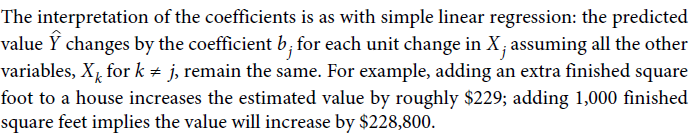

## Assessing the Model
Scikit-learn provides a number of metric to determine the quality of a model. Here we use the `r2_score`

In [27]:
"""scikit-learn provides a number of metrics for regression and classification. Here,
we use mean_squared_error to get RMSE and r2_score for the coefficient of
determination:"""
fitted = house_lm.predict(house[predictors])
RMSE = np.sqrt(mean_squared_error(house[outcome], fitted))
r2 = r2_score(house[outcome], fitted)
print(f'RMSE: {RMSE:.0F}')
print(f'r2: {r2:.4f}')

RMSE: 261220
r2: 0.5406


While _scikit-learn_ provides a variety of different metrics, _statsmodels_ provides a more in-depth analysis of the linear regression model. This package has two different ways of specifying the model, one that is similar to _scikit-learn_ and one that allows specifying _R_-style formulas. Here we use the first approach. As _statsmodels_ doesn't add an intercept automaticaly, we need to add a constant column with value 1 to the predictors. We can use the _pandas_ method assign for this.

In [28]:
#Use statsmodels to get a more detailed analysis of the regression model in Python
model = sm.OLS(house[outcome], house[predictors].assign(const=1))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     5338.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        20:02:06   Log-Likelihood:            -3.1517e+05
No. Observations:               22687   AIC:                         6.304e+05
Df Residuals:                   22681   BIC:                         6.304e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   228.8306      3.899     58.694

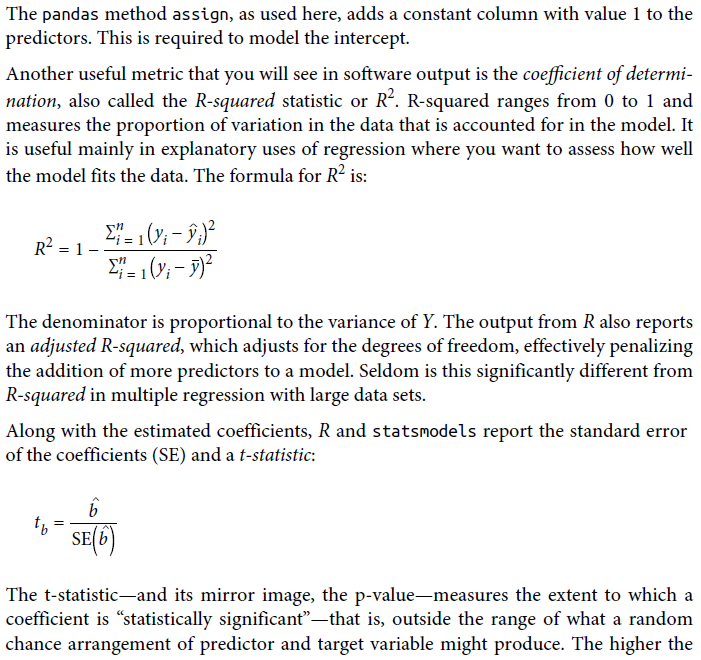
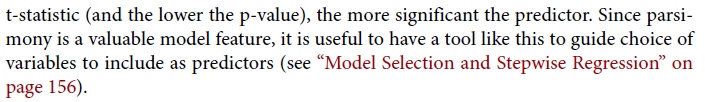

## Model Selection and Stepwise Regression

In some problems, many variables could be used as predictors in a regression. For
example, to predict house value, additional variables such as the basement size or
year built could be used

In [29]:
#In Python, we need to convert the categorical and boolean variables into numbers:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]

house_full = sm.OLS(house[outcome], X.assign(const=1))
results = house_full.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     2771.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        21:18:48   Log-Likelihood:            -3.1375e+05
No. Observations:               22687   AIC:                         6.275e+05
Df Residuals:                   22674   BIC:                         6.276e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
SqFtTotLiving       

We can use the `stepwise_selection` method from the dmba package.

In [31]:
""""
scikit-learn has no implementation for stepwise regression. We implemented functions
stepwise_selection, forward_selection, and backward_elimination in our dmba package:
"""
y = house[outcome]

# Define a function that returns a fitted model for a given of variables.
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X[variables], y)
    return model

# Define a function that returns a score for a given model and set of variables.
# In the case,we use AIC_score implemented in dmba package.
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(y, [y.mean()] * len(y), model, df=1)
    return AIC_score(y, model.predict(X[variables]), model)

best_model, best_variables = stepwise_selection(X.columns, train_model, score_model, verbose=True)

# Correlated Predictors
# In multiple regression, the predictor variables are often correlated with each other. As
# an example, examine the regression coefficients for the model step_lm, fit in

print()
print(f"Intercept: {best_model.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(best_variables, best_model.coef_):
    print(f" {name}: {coef}")

Variables: SqFtTotLiving, SqFtLot, Bathrooms, Bedrooms, BldgGrade, NbrLivingUnits, SqFtFinBasement, YrBuilt, YrRenovated, NewConstruction, PropertyType_Single Family, PropertyType_Townhouse
Start: score=647988.32, constant
Step: score=633013.35, add SqFtTotLiving
Step: score=630793.74, add BldgGrade
Step: score=628230.29, add YrBuilt
Step: score=627784.16, add Bedrooms
Step: score=627602.21, add Bathrooms
Step: score=627525.65, add PropertyType_Townhouse
Step: score=627525.08, add SqFtFinBasement
Step: score=627524.98, add PropertyType_Single Family
Step: score=627524.98, unchanged None

Intercept: 6178645.017
Coefficients:
 SqFtTotLiving: 199.27755304201617
 BldgGrade: 137159.56022619744
 YrBuilt: -3565.4249392494553
 Bedrooms: -51947.38367361353
 Bathrooms: 42396.16452772067
 PropertyType_Townhouse: 84479.16203300106
 SqFtFinBasement: 7.04697496757506
 PropertyType_Single Family: 22912.055187017686


The coefficient for Bedrooms is negative! This implies that adding a bedroom to a
house will reduce its value. How can this be? This is because the predictor variables
are correlated: larger houses tend to have more bedrooms, and it is the size that drives
house value, not the number of bedrooms. Consider two homes of the exact same
size: it is reasonable to expect that a home with more but smaller bedrooms would be
considered less desirable.

## Weighted Regression
We can calculate the Year from the date column using either a list comprehension or data frame's `apply` method.
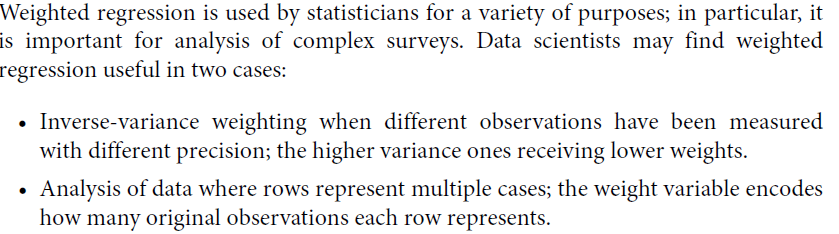
For example, with the housing data, older sales are less reliable than more recent
sales. Using the DocumentDate to determine the year of the sale, we can compute a
Weight as the number of years since 2005 (the beginning of the data):

In [32]:
house['Year'] = [int(date.split('-')[0]) for date in house.DocumentDate]
house['Year'] = house.DocumentDate.apply(lambda d: int(d.split('-')[0]))
house['Weight'] = house.Year - 2005                     

In [40]:
# Most models in scikit-learn accept weights as the keyword argument sample_weight in the call of the fit method:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_wt = LinearRegression()
house_wt.fit(house[predictors], house[outcome], sample_weight=house.Weight)
pd.DataFrame({
    'predictor': predictors,
    'house_lm': house_lm.coef_,
    'house_wt': house_wt.coef_,
}).append({
    'predictor': 'intercept',
    'house_lm': house_lm.intercept_,
    'house_wt': house_wt.intercept_,
}, ignore_index=True)



,predictor,house_lm,house_wt
0,SqFtTotLiving,228.830604,245.024089
1,SqFtLot,-0.060467,-0.292415
2,Bathrooms,-19442.840398,-26085.970109
3,Bedrooms,-47769.955185,-53608.876436
4,BldgGrade,106106.963079,115242.434726
5,intercept,-521871.368188,-584189.329446


In [46]:
Residulas = pd.DataFrame({
    'abs_residual': np.abs(house_lm.predict(house[predictors]) - house[outcome]),
    'abs_residual': np.abs(house_wt.predict(house[predictors]) - house[outcome]),
    'Year': house['Year'],
})
print(residuals.head())
# axes = residuals.boxplot(['abs_resuduals_lm', 'abs_residuals_wt'], by='Year', figsize=(10, 4))
# axes[0].set_ylim(0, 300000)


pd.DataFrame(([year, np.mean(group['abs_residual_lm']), np.mean(group['abs_residual_wt'])]
            for year, group in residuals.groupby('Year')),
            columns=['Year', 'mean abs_residual_lm', 'mean abs_residual_wt'])

# for year, group in residuals.groupby('Year'):
#     print(year, np.mean(group['abs_residual_lm']), np,mean(group['abs_residual_wt']))

   abs_residual_lm  abs_residual_wt  Year
1    123750.814194    107108.553965  2014
2     59145.413089     96191.882094  2006
3    190108.725716    187004.492880  2007
4    198788.774412    196132.996857  2008
5     91774.996129     84277.577512  2013


,Year,mean abs_residual_lm,mean abs_residual_wt
0,2006,140540.303585,146557.454636
1,2007,147747.577959,152848.523235
2,2008,142086.905943,146360.411668
3,2009,147016.720883,151182.924825
4,2010,163267.674885,166364.476152
5,2011,169937.385744,172950.876028
6,2012,169506.670053,171874.424266
7,2013,203659.777510,206242.199403
8,2014,184452.840665,186668.573750
9,2015,172323.435147,169842.742053


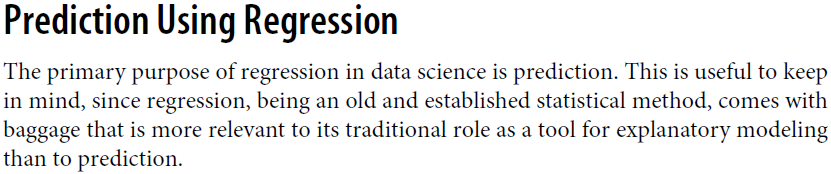



## Factor Variables in Regression
### Dummy Variables Respresentaion
In King Country housing data, there is a factor varialble for the property type; a small subset of six records is shown below:

we can convert categorical variables to dummies using the pandas method
get_dummies:

In [47]:
print(house.PropertyType.head())

1        Multiplex
2    Single Family
3    Single Family
4    Single Family
5    Single Family
Name: PropertyType, dtype: object


In [48]:
# By default, returns one hot encoding of the categorical variable
print(pd.get_dummies(house['PropertyType'].head(6)))

   Multiplex  Single Family  Townhouse
1          1              0          0
2          0              1          0
3          0              1          0
4          0              1          0
5          0              1          0
6          0              0          1


In [53]:
# The keyword argument drop_first will return P - 1 columns. use this to avoid the problem of multicollinearity.
print(pd.get_dummies(house['PropertyType'], drop_first=True).head(6))

   Single Family  Townhouse
1              0          0
2              1          0
3              1          0
4              1          0
5              1          0
6              0          1


In [52]:
# The method get_dummies takes the optional keyword argument drop_first toexclude the first factor as reference:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType']

X = pd.get_dummies(house[predictors], drop_first=True)

house_lm_factor = LinearRegression()
house_lm_factor.fit(X, house[outcome])

print(f"Intercept: {house_lm_factor.intercept_:.3f}")
print("Coefficients:")
for name, coef in zip(X.columns, house_lm_factor.coef_):
    print(f" {name}: {coef}")

Intercept: -446841.366
Coefficients:
 SqFtTotLiving: 223.3736289250382
 SqFtLot: -0.07036798136812546
 Bathrooms: -15979.013473415192
 Bedrooms: -50889.73218483024
 BldgGrade: 109416.30516146187
 PropertyType_Single Family: -84678.21629549268
 PropertyType_Townhouse: -115121.9792160919


## Factor Variables with many levels

In [59]:
print(pd.DataFrame(house['ZipCode'].value_counts()).transpose())


         98038  98103  98042  98115  98117  98052  98034  98033  98059  98074  \
ZipCode    788    671    641    620    619    614    575    517    513    502   

         ...  98051  98024  98354  98050  98288  98057  98224  98113  98043  \
ZipCode  ...     32     31      9      7      4      4      3      1      1   

         98068  
ZipCode      1  

[1 rows x 80 columns]


In [75]:
house = pd.read_csv(HOUSE_CSV, sep='\t')

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 
              'Bedrooms', 'BldgGrade']
outcome = 'AdjSalePrice'

house_lm = LinearRegression()
house_lm.fit(house[predictors], house[outcome])

"""
The median residual is computed for each zip, and the ntile function is used to split
the zip codes, sorted by the median, into five groups. See “Confounding Variables” on
page 172 for an example of how this is used as a term in a regression improving upon
the original fit.
"""

zip_groups = pd.DataFrame([
    *pd.DataFrame({
        'ZipCode': house['ZipCode'],
        'residual': house[outcome] - house_lm.predict(house[predictors]),
    })
    .groupby(['ZipCode'])
    .apply(lambda x: {
        'ZipCode': x.iloc[0,0],
        'count': len(x),
        'median_residual': x.residual.median()
    })
]).sort_values('median_residual')
zip_groups['cum_count'] = np.cumsum(zip_groups['count'])
zip_groups['ZipGroup'] = pd.qcut(zip_groups['cum_count'], 5, labels=False, retbins=False)
zip_groups.head()
print(zip_groups.ZipGroup.value_counts().sort_index())

# The concept of using the residuals to help guide the regression fitting is a fundamental
# step in the modeling process; see “Regression Diagnostics” on page 176.



0    16
1    16
2    16
3    16
4    16
Name: ZipGroup, dtype: int64


In [76]:
to_join = zip_groups[['ZipCode', 'ZipGroup']].set_index('ZipCode')
house = house.join(to_join, on='ZipCode')
house['ZipGroup'] = house['ZipGroup'].astype('category')

## Interpreting the Regression Equation
### Correlated predictors
In multiple regression, the predictor variables are often correlated with each other. As
an example, examine the regression coefficients for the model step_lm, fit in “Model
Selection and Stepwise Regression” on page 156.


The results from the stepwise regrssion are.

In [79]:
print(f"Intercept: {best_model.intercept_:.3f}")
print("Coeficients:")

for name, coef in zip(best_variables, best_model.coef_):
    print(f" {name}: {coef}")

Intercept: 6178645.017
Coeficients:
 SqFtTotLiving: 199.27755304201617
 BldgGrade: 137159.56022619744
 YrBuilt: -3565.4249392494553
 Bedrooms: -51947.38367361353
 Bathrooms: 42396.16452772067
 PropertyType_Townhouse: 84479.16203300106
 SqFtFinBasement: 7.04697496757506
 PropertyType_Single Family: 22912.055187017686


The coefficient for Bedrooms is negative! This implies that adding a bedroom to a
house will reduce its value. How can this be? This is because the predictor variables
are correlated: larger houses tend to have more bedrooms, and it is the size that drives
house value, not the number of bedrooms. Consider two homes of the exact same
size: it is reasonable to expect that a home with more but smaller bedrooms would be
considered less desirable.

Having correlated predictors can make it difficult to interpret the sign and value of
regression coefficients (and can inflate the standard error of the estimates). The variables
for bedrooms, house size, and number of bathrooms are all correlated


which fits another regression removing the
variables SqFtTotLiving, SqFtFinBasement, and Bathrooms from the equation


The update function can be used to add or remove variables from a model. Now the
coefficient for bedrooms is positive—in line with what we would expect (though it is
really acting as a proxy for house size, now that those variables have been removed).
In Python, there is no equivalent to R’s update function. We need to refit the model
with the modified predictor list

In [84]:
predictors = ['Bedrooms', 'BldgGrade', 'PropertyType', 'YrBuilt']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)

reduced_lm = LinearRegression()
reduced_lm.fit(X, house[outcome])

print(f"Intercept: {reduced_lm.intercept_:.3f}")
print("Coefficients")
for name, coef in zip(X.columns, reduced_lm.coef_):
    print(f" {name}: {coef}")

Intercept: 4913973.344
Coefficients
 Bedrooms: 27150.53723021616
 BldgGrade: 248997.79366213715
 YrBuilt: -3211.744862155116
 PropertyType_Single Family: -19898.49534050251
 PropertyType_Townhouse: -47355.43687334504


Correlated variables are only one issue with interpreting regression coefficients. In
house_lm, there is no variable to account for the location of the home, and the model is mixing together very different types of regions. Location may be a confounding
variable; see “Confounding Variables” on page 172 for further discussion

## Confounding Variables

With correlated variables, the problem is one of commission: including different variables
that have a similar predictive relationship with the response. With confounding
variables, the problem is one of omission: an important variable is not included in the
regression equation. Naive interpretation of the equation coefficients can lead to invalid
conclusions.

Take, for example, the King County regression equation house_lm from “Example:
King County Housing Data” on page 151. The regression coefficients of SqFtLot,
Bathrooms, and Bedrooms are all negative. The original regression model does not
contain a variable to represent location—a very important predictor of house price.
To model location, include a variable ZipGroup that categorizes the zip code into one
of five groups, from least expensive (1) to most expensive (5):

In [91]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'ZipGroup']
outcome = 'AdjSalePrice'

# print(house[predictors].head(10))
X = pd.get_dummies(house[predictors], drop_first=True)

confounding_lm = LinearRegression()
confounding_lm.fit(X, house[outcome])

print(f'Intercept: {confounding_lm.intercept_:.3f}')
print("Coefficients:")
for name, coef in zip(X.columns, confounding_lm.coef_):
    print(f' {name}: {coef}')

Intercept: -666637.469
Coefficients:
 SqFtTotLiving: 210.61266005580183
 SqFtLot: 0.4549871385465901
 Bathrooms: 5928.425640001864
 Bedrooms: -41682.871840744745
 BldgGrade: 98541.18352725943
 PropertyType_Single Family: 19323.625287919334
 PropertyType_Townhouse: -78198.72092762386
 ZipGroup_1: 53317.173306597986
 ZipGroup_2: 116251.58883563547
 ZipGroup_3: 178360.53178793367
 ZipGroup_4: 338408.60185652017


ZipGroup is clearly an important variable: a home in the most expensive zip code
group is estimated to have a higher sales price by almost `$340,000`. The coefficients of
SqFtLot and Bathrooms are now positive, and adding a bathroom increases the sale
price by `$5,928.`

The coefficient for Bedrooms is still negative. While this is unintuitive, this is a wellknown
phenomenon in real estate. For homes of the same livable area and number of
bathrooms, having more and therefore smaller bedrooms is associated with less valuable
homes.

## Interactions and Main Effects

Statisticians like to distinguish between main effects, or independent variables, and
the interactions between the main effects. Main effects are what are often referred to
as the predictor variables in the regression equation. An implicit assumption when
only main effects are used in a model is that the relationship between a predictor
variable and the response is independent of the other predictor variables. This is
often not the case.


In Python, we need to use the statsmodels package to train linear regression models
with interactions

In [92]:
model = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving*ZipGroup + SqFtLot + ' +
                   'Bathrooms + Bedrooms + BldgGrade + PropertyType', data=house)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     3247.
Date:                Mon, 28 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:02:07   Log-Likelihood:            -3.1098e+05
No. Observations:               22687   AIC:                         6.220e+05
Df Residuals:                   22671   BIC:                         6.221e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

> Results differ from R due to different binning. Enforcing the same binning gives identical results

## Testing the Assumptions: Regression Diagnostics
In explanatory modeling (i.e., in a research context), various steps, in addition to the
metrics mentioned previously (see “Assessing the Model” on page 153), are taken to
assess how well the model fits the data; most are based on analysis of the residuals.
These steps do not directly address predictive accuracy, but they can provide useful
insight in a predictive setting.
### Outliers
Generally speaking, an extreme value, also called an outlier, is one that is distant from
most of the other observations. Just as outliers need to be handled for estimates of
location and variability (see “Estimates of Location” on page 7 and “Estimates of Variability”
on page 13), outliers can cause problems with regression models. In regression,
an outlier is a record whose actual y value is distant from the predicted value.
You can detect outliers by examining the standardized residual, which is the residual
divided by the standard error of the residuals.


The statsmodels package has the most developed support for outlier analysis.

In [95]:
# Let’s fit a regression to the King County house sales data for all sales in zip code 98105
house_98105 = house.loc[house['ZipCode'] == 98105,]

predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade']
outcome = 'AdjSalePrice'

house_outlier = sm.OLS(house_98105[outcome], house_98105[predictors].assign(const=1))
results_98105 = house_outlier.fit()
print(results_98105.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     238.7
Date:                Mon, 28 Feb 2022   Prob (F-statistic):          1.69e-103
Time:                        22:27:42   Log-Likelihood:                -4226.0
No. Observations:                 313   AIC:                             8464.
Df Residuals:                     307   BIC:                             8486.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
SqFtTotLiving   209.6023     24.408      8.587

The `OLSInfluence` class is initialized with the OLS regression results and gives access to a number of usefule properties. Here we use the studentized residuals.

In [96]:
# In statsmodels, use OLSInfluence to analyze the residuals
influence = OLSInfluence(results_98105)
sresiduals = influence.resid_studentized_internal

print(sresiduals.idxmin(), sresiduals.min())

24333 -4.326731804078567


The biggest overestimate from the model is more than four standard errors above the
regression line, corresponding to an overestimate of $757,754. The original data
record corresponding to this outlier

In [97]:
print(results_98105.resid.loc[sresiduals.idxmin()])

-757753.6192115835


In [98]:
outlier = house_98105.loc[sresiduals.idxmin(), :]
print('AdjSalePriece', outlier[outcome])
print(outlier[predictors])

AdjSalePriece 119748.0
SqFtTotLiving    2900
SqFtLot          7276
Bathrooms         3.0
Bedrooms            6
BldgGrade           7
Name: 24333, dtype: object


In this case, it appears that there is something wrong with the record: a house of that
size typically sells for much more than $119,748 in that zip code. Figure 4-4 shows an
excerpt from the statutory deed from this sale: it is clear that the sale involved only
partial interest in the property. In this case, the outlier corresponds to a sale that is
anomalous and should not be included in the regression. Outliers could also be the
result of other problems, such as a “fat-finger” data entry or a mismatch of units (e.g.,
reporting a sale in thousands of dollars rather than simply in dollars).

> For big data problems, outliers are generally not a problem in fitting the regression to
be used in predicting new data. However, outliers are central to anomaly detection,
where finding outliers is the whole point. The outlier could also correspond to a case
of fraud or an accidental action. In any case, detecting outliers can be a critical business
need

## Influential Values

A value whose absence would significantly change the regression equation is termed
an influential observation. In regression, such a value need not be associated with a
large residual. As an example, consider the regression lines in Figure 4-5. The solid
line corresponds to the regression with all the data, while the dashed line corresponds
to the regression with the point in the upper-right corner removed. Clearly, that data
value has a huge influence on the regression even though it is not associated with a
large outlier (from the full regression). This data value is considered to have high leverage
on the regression.

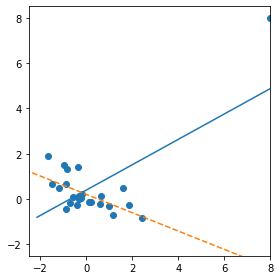

Figure 4-5 An example of an influential data point in regression


In [103]:
%matplotlib inline
from scipy.stats import linregress

np.random.seed(5)
x = np.random.normal(size=25)
y = -x / 5 + np.random.normal(size=25)
x[0] = 8
y[0] = 8

def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)
slope, intercept, _, _, _ = linregress(x, y)
ax.plot(*abline(slope, intercept, ax))
slope, intercept, _, _, _ = linregress(x[1:], y[1:])
ax.plot(*abline(slope, intercept, ax), '--')
ax.set_xlim(-2.5, 8,5)
ax.set_ylim(-2.5, 8.5)

plt.tight_layout()
plt.show()
print("Figure 4-5 An example of an influential data point in regression")

The package statsmodel provides a number of plots to analyze the data point influence

>An influence plot or bubble plot combines standardized residuals, the hat-value, and
Cook’s distance in a single plot. Figure 4-6 shows the influence plot for the King
County house data and can be created

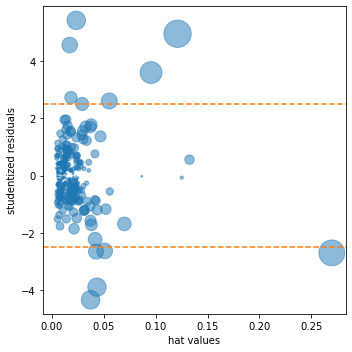

Figure 4-6. A plot to determine which observations have high influence; points with
Cook’s distance greater than 0.08 are highlighted in grey


In [107]:
infuence = OLSInfluence(results_98105)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.hat_matrix_diag, influence.resid_studentized_internal,
           s=1000 * np.sqrt(influence.cooks_distance[0]),
          alpha=0.5)

ax.set_xlabel('hat values')
ax.set_ylabel('studentized residuals')

plt.tight_layout()
plt.show()
print("""Figure 4-6. A plot to determine which observations have high influence; points with
Cook’s distance greater than 0.08 are highlighted in grey""")

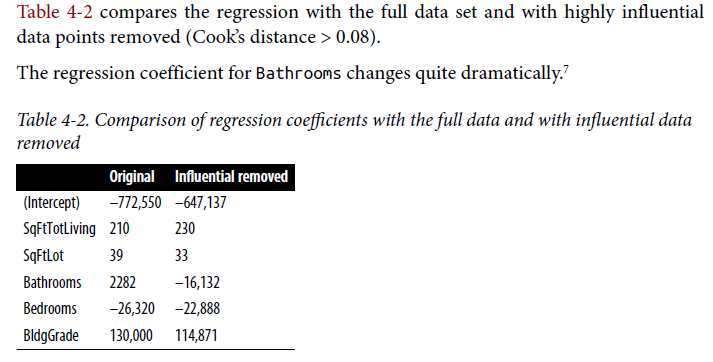

In [111]:
mask = [dist < .08 for dist in influence.cooks_distance[0]]
house_infl = house_98105.loc[mask]

ols_infl = sm.OLS(house_infl[outcome], house_infl[predictors].assign(const=1))
result_infl = ols_infl.fit()

pd.DataFrame({
    'Orginal': results_98105.params,
    'Influential': result_infl.params,
})

,Orginal,Influential
SqFtTotLiving,209.602346,230.052569
SqFtLot,38.933315,33.141600
Bathrooms,2282.264145,-16131.879785
Bedrooms,-26320.268796,-22887.865318
BldgGrade,130000.099737,114870.559737
const,-772549.862447,-647137.096716


## Heteroskedasticity, Non-Normality and Correlates Errors

The `rgplot` in seabron allows adding a lowees smoothing line to the scatterplot

Heteroskedasticity is the lack of constant residual variance across the range of the predicted
values. In other words, errors are greater for some portions of the range than
for others. Visualizing the data is a convenient way to analyze residuals.
The following code in R plots the absolute residuals versus the predicted values for
the lm_98105 regression fit in “Outliers” on page 177:

Figure 4-7 shows the resulting plot. Using geom_smooth, it is easy to superpose a
smooth of the absolute residuals. The function calls the loess method (locally estimated
scatterplot smoothing) to produce a smoothed estimate of the relationship
between the variables on the x-axis and y-axis in a scatterplot (see “Scatterplot
Smoothers” on page 185).

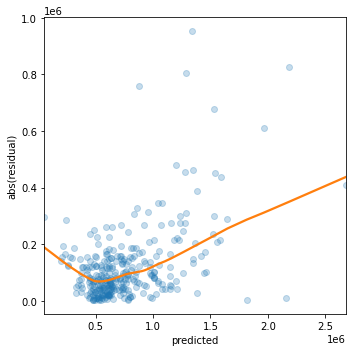

Figure 4-7. A plot of the absolute value of the residuals versus the predicted values


In [116]:
# the seaborn package has the regplot function to create a similar figure:
fig, ax = plt.subplots(figsize=(5, 5))
sns.regplot(x=results_98105.fittedvalues, y=np.abs(results_98105.resid),
            scatter_kws={'alpha':0.25},
            line_kws={'color': 'C1'},
            lowess=True, ax=ax)

ax.set_xlabel('predicted')
ax.set_ylabel('abs(residual)')

plt.tight_layout()
plt.show()

print("Figure 4-7. A plot of the absolute value of the residuals versus the predicted values")

Evidently, the variance of the residuals tends to increase for higher-valued homes but
is also large for lower-valued homes. This plot indicates that lm_98105 has heteroskedastic
errors.

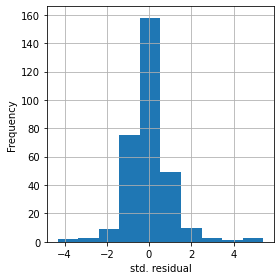

Figure 4-8. A histogram of the residuals from the regression of the housing data


In [114]:
fig, ax = plt.subplots(figsize=(4, 4))
pd.Series(influence.resid_studentized_internal).hist(ax=ax)
ax.set_xlabel('std. residual')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Figure 4-8. A histogram of the residuals from the regression of the housing data")

Figure 4-8 is a histogram of the standardized residuals for the lm_98105 regression.
The distribution has decidedly longer tails than the normal distribution and exhibits
mild skewness toward larger residuals.


Statisticians may also check the assumption that the errors are independent. This is
particularly true for data that is collected over time or space. The Durbin-Watson statistic
can be used to detect if there is significant autocorrelation in a regression
involving time series data. If the errors from a regression model are correlated, then
this information can be useful in making short-term forecasts and should be built
into the model. See Practical Time Series Forecasting with R, 2nd ed., by Galit Shmueli
and Kenneth Lichtendahl (Axelrod Schnall, 2018) to learn more about how to build
autocorrelation information into regression models for time series data. If longerterm
forecasts or explanatory models are the goal, excess autocorrelated data at the
microlevel may distract. In that case, smoothing, or less granular collection of data in
the first place, may be in order.
Even though a regression may violate one of the distributional assumptions, should
we care? Most often in data science, the interest is primarily in predictive accuracy, so
some review of heteroskedasticity may be in order. You may discover that there is
some signal in the data that your model has not captured. However, satisfying distributional
assumptions simply for the sake of validating formal statistical inference (pvalues,
F-statistics, etc.) is not that important for the data scientist.

## Partial Residual Plots and Nonlinenearity
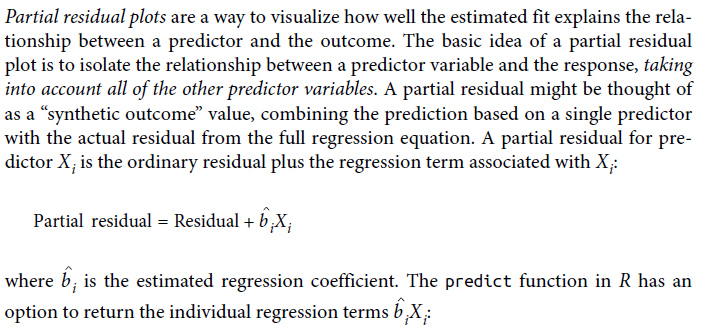

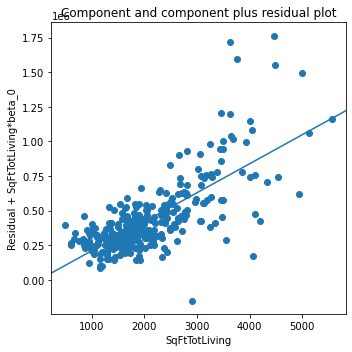

Figure 4-9. A partial residual plot for the variable SqFtTotLiving


In [123]:
fig, ax = plt.subplots(figsize=(5, 5))
fig = sm.graphics.plot_ccpr(results_98105, 'SqFtTotLiving', ax=ax)

plt.tight_layout()
plt.show()
print("Figure 4-9. A partial residual plot for the variable SqFtTotLiving")

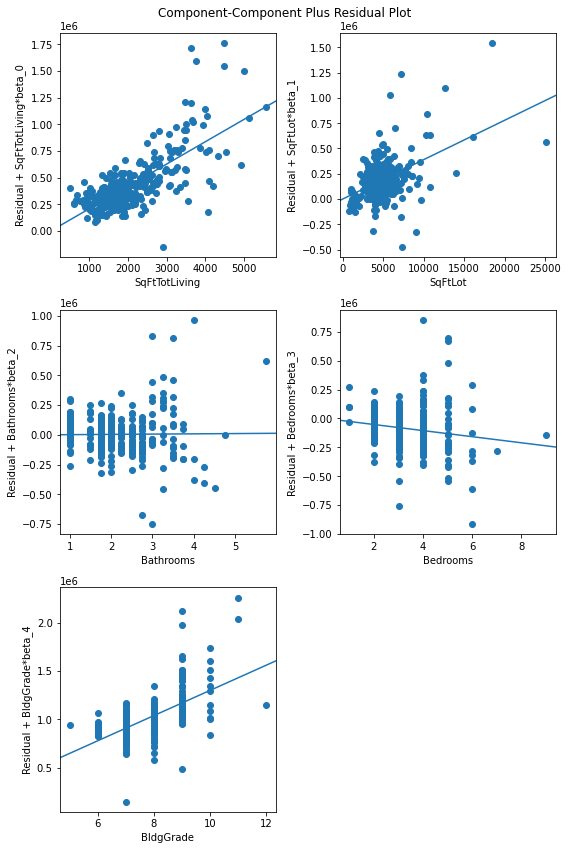

In [122]:
fig = plt.figure(figsize=(8, 12))
fig = sm.graphics.plot_ccpr_grid(results_98105, fig=fig)

## Polynominal and Spline Regression
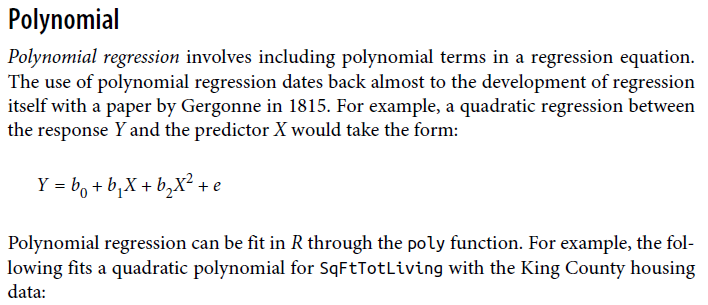

In [127]:
model_poly = smf.ols(formula='AdjSalePrice ~ SqFtTotLiving + np.power(SqFtTotLiving, 2) + ' + 
                     'SqFtLot + Bathrooms + Bedrooms + BldgGrade', data=house_98105)
result_poly = model_poly.fit()
print(result_poly.summary())
# The intercept and the polynomial coefficients are different compared to R. This is
# due to different implementations. The remaining coefficients and the predictions
# are equivalent

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     211.6
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          9.95e-106
Time:                        14:44:05   Log-Likelihood:                -4217.9
No. Observations:                 313   AIC:                             8450.
Df Residuals:                     306   BIC:                             8476.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The statsmodels implementation of a partial residual plot works only for linear trem. Here is an implementation of a partial residual plot that, while inefficient, works for the polynominal regression.
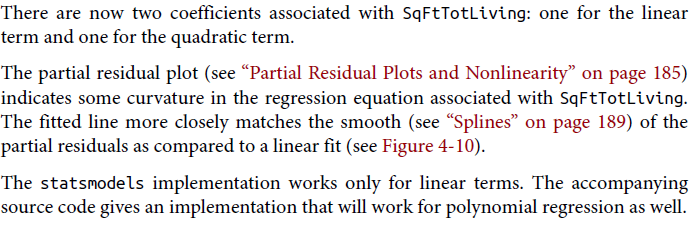

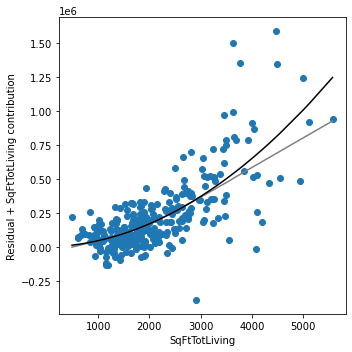

0.03879128168237239
Figure 4-10. A polynomial regression fit for the variable SqFtTotLiving (solid line) versus
a smooth (dashed line; see the following section about splines)


In [133]:
def partialResidualPlot(model, df, outcome, feature, ax):
    y_pred = model.predict(df)
    copy_df = df.copy()
    for c in copy_df.columns:
        if c == feature:
            continue
        copy_df[c] = 0.0
    feature_prediction = model.predict(copy_df)
    results = pd.DataFrame({
        'feature': df[feature],
        'residual': df[outcome] - y_pred,
        'ypartial': feature_prediction - model.params[0],
    })
    results = results.sort_values(by=['feature'])
    smoothed = sm.nonparametric.lowess(results.ypartial, results.feature, frac=1/3)
    
    ax.scatter(results.feature, results.ypartial + results.residual)
    ax.plot(smoothed[:, 0], smoothed[:, 1], color='gray')
    ax.plot(results.feature, results.ypartial, color='black')
    ax.set_xlabel(feature)
    ax.set_ylabel(f"Residual + {feature} contribution")
    return ax

fig, ax = plt.subplots(figsize=(5, 5))
partialResidualPlot(result_poly, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print(result_poly.params[2])
print("""Figure 4-10. A polynomial regression fit for the variable SqFtTotLiving (solid line) versus
a smooth (dashed line; see the following section about splines)""")

## Splines
Polynomial regression captures only a certain amount of curvature in a nonlinear
relationship. Adding in higher-order terms, such as a cubic quartic polynomial, often leads to undesirable “wiggliness” in the regression equation. An alternative, and often
superior, approach to modeling nonlinear relationships is to use splines. Splines provide
a way to smoothly interpolate between fixed points. Splines were originally used
by draftsmen to draw a smooth curve, particularly in ship and aircraft building.
The splines were created by bending a thin piece of wood using weights, referred to as
“ducks”; see Figure 4-11.

In [135]:
formula = ('AdjSalePrice ~ bs(SqFtTotLiving, df=6, degree=3) + ' + 
           'SqFtLot + Bathrooms + Bedrooms + BldgGrade')
model_spline = smf.ols(formula=formula, data=house_98105)
result_spline = model_spline.fit()
print(result_spline.summary())

                            OLS Regression Results                            
Dep. Variable:           AdjSalePrice   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     131.8
Date:                Tue, 01 Mar 2022   Prob (F-statistic):          7.10e-104
Time:                        15:33:28   Log-Likelihood:                -4211.4
No. Observations:                 313   AIC:                             8445.
Df Residuals:                     302   BIC:                             8486.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


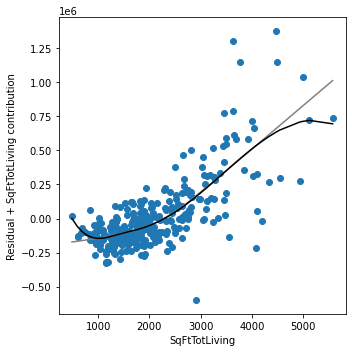

Figure 4-12. A spline regression fit for the variable SqFtTotLiving (solid line) compared
to a smooth (dashed line)


In [136]:
fig, ax = plt.subplots(figsize=(5,5))
partialResidualPlot(result_spline, house_98105, 'AdjSalePrice', 'SqFtTotLiving', ax)

plt.tight_layout()
plt.show()
print("""Figure 4-12. A spline regression fit for the variable SqFtTotLiving (solid line) compared
to a smooth (dashed line)""")

## Generalized Additive Models

In [169]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms',
              'Bedrooms', 'BldgGrade']

outcome = 'AdjSalePrice'
X = house_98105[predictors].values
y = house_98105[outcome]

## model
# The default value for n_splines is 20. This leads to overfitting for larger SqFtTot
# Living values. A value of 12 leads to a more reasonable fit.
gam = LinearGAM(s(0, n_splines=12) + l(1) + l(3) + l(4))
gam.gridsearch(X, y)
print(gam.summary())

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.8517
Link Function:                     IdentityLink Log Likelihood:                                 -7832.2275
Number of Samples:                          313 AIC:                                            15680.1585
                                                AICc:                                           15680.6155
                                                GCV:                                      30600169696.0614
                                                Scale:                                    29396841663.4945
                                                Pseudo R-Squared:                                   0.8118
Feature Function                  Lam

<ipython-input-169-e2c8ef6883d2>:13: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


ValueError: cannot create grid for intercept term

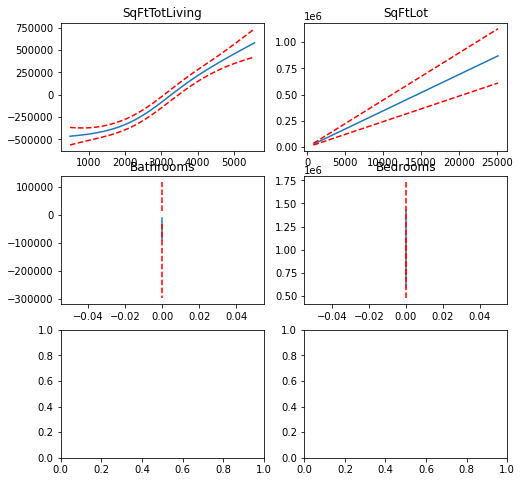

In [170]:
fig, axes = plt.subplots(figsize=(8, 8), ncols=2, nrows=3)

titles = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms', 'BldgGrade']
for i, title in enumerate(titles):
    ax = axes[i // 2, i % 2]
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i]);
    
axes[2][1].set_visible(False)

plt.tight_layout()
plt.show()

## Additional material - not in book
## Regularization
## Lasso

In [157]:
from sklearn.linear_model import Lasso, LassoLars, LassoCV, LassoLarsCV
from sklearn.preprocessing import StandardScaler

In [160]:
subset = ['AdjSalePrice', 'SqFtTotLiving', 'SqFtLot', 'Bathrooms',
         'Bedrooms', 'BldgGrade']

house = pd.read_csv(HOUSE_CSV, sep='\t')
print(house[subset].head())

   AdjSalePrice  SqFtTotLiving  SqFtLot  Bathrooms  Bedrooms  BldgGrade
1      300805.0           2400     9373       3.00         6          7
2     1076162.0           3764    20156       3.75         4         10
3      761805.0           2060    26036       1.75         4          8
4      442065.0           3200     8618       3.75         5          7
5      297065.0           1720     8620       1.75         4          7


In [161]:
predictors = ['SqFtTotLiving', 'SqFtLot', 'Bathrooms', 'Bedrooms',
              'BldgGrade', 'PropertyType', 'NbrLivingUnits',
              'SqFtFinBasement', 'YrBuilt', 'YrRenovated', 
              'NewConstruction']
outcome = 'AdjSalePrice'

X = pd.get_dummies(house[predictors], drop_first=True)
X['NewConstruction'] = [1 if nc else 0 for nc in X['NewConstruction']]
columns = X.columns
# X = StandartScaler().fit_transform(X * 1.0)
y = house[outcome]

house_lm = LinearRegression()
print(house_lm.fit(X, y))

LinearRegression()


In [162]:
house_lasso = Lasso(alpha=10)
print(house_lasso.fit(X, y))

Lasso(alpha=10)


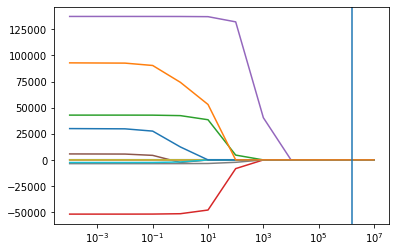

In [164]:
Method = LassoLars
MethodCV = LassoLarsCV
method = Lasso
MethodCV = LassoCV

alpha_values = []
results = []
for alpha in [0.0001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]:
    model = Method(alpha=alpha)
    model.fit(X, y)
    alpha_values.append(alpha)
    results.append(model.coef_)
modelCV = MethodCV(cv=5)
modelCV.fit(X, y)
ax = pd.DataFrame(results, index=alpha_values, columns=columns).plot(logx=True, legend=False)
ax.axvline(modelCV.alpha_)
plt.show()

In [165]:
pd.DataFrame({
    'name': columns,
    'coef': modelCV.coef_,
})

,name,coef
0,SqFtTotLiving,289.048846
1,SqFtLot,0.029471
2,Bathrooms,0.000000
3,Bedrooms,-0.000000
4,BldgGrade,0.000000
5,NbrLivingUnits,-0.000000
6,SqFtFinBasement,3.316479
7,YrBuilt,-0.000000
8,YrRenovated,45.727472
9,NewConstruction,-0.000000


In [167]:
# Intercept: 6177658.144
# Coefficients:
#  SqFtTotLiving: 199.27474217544048
#  BldgGrade: 137181.13724627026
#  YrBuilt: -3564.934870415041
#  Bedrooms: -51974.76845567939
#  Bathrooms: 42403.059999677665
#  PropertyType_Townhouse: 84378.9333363999
#  SqFtFinBasement: 7.032178917565108
#  PropertyType_Single Family: 22854.87954019308

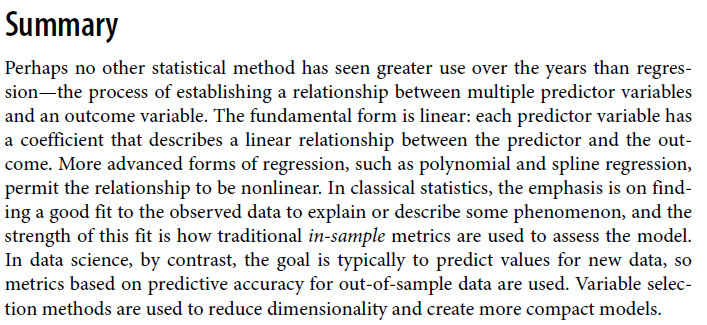